In [4]:
%config Completer.use_jedi = False

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tabulate import tabulate as tb

np.set_printoptions(suppress=True)

$$||X - C||_{2}^{2} = diag(XX^{T}) + 1_{n}diag(CC^{T})^{T} - 2XC^{T} = \sum_{i}(X \circ X)_{ij} + 1_{n}diag(CC^{T})^{T} - 2XC^{T}$$

In [21]:
import numpy as np

def calc_l2_norm(X, C):
    """
    Vectorized l2-norm that calculates Euclidean distance between 
    every observation and centroid vector. This method produces
    a matrix of shape (m, K) where column vectors denote the
    distances between Kth centroid and every single observation.
    
    For faster calculations it uses Hadamard product to get the first
    term of vectorized l2-norm equation. Distance matrix is calculated
    as:
        $$||X - C||_{2}^{2} = \sum_{i}(X \circ X)_{ij} + 1_{n}diag(CC^{T})^{T} - 2XC^{T}$$
        
    Args:
        X (ndarray):    (m, n) Data points
        C (ndarray):    (K, n) Centroids
        
    Returns:
        Dist (ndarray): (m, K) Euclidean distance matrix
    """
    
    # calculate the distance matrix
    Dist = \
        (X * X).sum(axis=-1).reshape(-1, 1) + \
        np.ones((X.shape[0], 1)) @ np.diag(C @ C.T).reshape(-1, 1).T - \
        2 * (X @ C.T)
    
    return Dist

def initialize_centroids(X, K, random_state=''):
    """
    Sample K random points from the data matrix. 
    Those points are our initial centroids.
    
    Args:
        X (ndarray):         (m, n) Data points
        K (int):             Number of centroids
        
    Returns:
        centroids (ndarray): (K, n) Initialized centroids
    """
    
    # initialize the seed
    if random_state != '':
        np.random.seed(random_state)
    
    # get the indices for K random data points
    ind = np.random.choice(
        np.arange(X.shape[0]),
        size=K
    )
    
    # get the centroids
    centroids = X[ind, :]
    
    return centroids

def find_closest_centroids_group(X, centroids):
    """
    Calculate indices of rows belonging to a given centroid 
    in a form of dictionary. It uses vectorized l2-norm to 
    find the closest data points to  a given centroid. If idx is
    False then it returns the array of cluster number for given data point.
    
    Args:
        X (ndarray):             (m, n) Data points
        centroids (ndarray):     (K, n) Centroids
        
    Returns:
        min_args (ndarray):      (m,) array of group numbers of clusters
    """
    
    # calculate the distances matrix
    dist = calc_l2_norm(X, centroids)
    
    # find the closest centroid 
    min_args = dist.argmin(axis=1)
    
    return min_args       

def compute_centroids(X, cluster_group, K):
    """
    Returns the new centroids by computing the mean of the 
    data points assigned to each centroid. 
    
    It starts by mapping all the centroids to zero vector, 
    and then assigns only the unique values from [0, K].
    All cetroids that after the process of assigment the 
    new vectors, stay mapped to the zero vector are deleted.
    It can happen that the number of centorids will be less K.
    
    Args:
        X (ndarray):   (m, n) Data points
        cluster_group (ndarray): (m,) Array of all unique values 
                                 from 1 to K that denotes the group
                                 number of every cluster.
    
    Returns:
        centroids (ndarray): (K, n) New centroids computed
    """
    
    # get only the unique cluster numbers
    unique_num = np.unique(cluster_group)
    
    # map all new centroids to zero vector
    centroids = np.zeros((K, X.shape[1]))

    for i in unique_num:
        
        # get the size of indices
        ind_size = (cluster_group == i).sum()
        
        # calculate new centroids
        centroids[i, :] = 1 / ind_size * X[cluster_group == i].sum(axis=0)
        
    # delete centroids that stayed mapped to zero vector
    centroids = np.delete(centroids, (centroids == 0).all(axis=1), axis=0)
    
    return centroids

def inertia(X, centroids):
    """
    Calculates the sum of squared distances of samples to their
    closest cluster center. It uses calc_l2_norm for Kth centroid 
    to get the values of inertia. And then sum all of the 
    values obtained.
    
    Args:
        X (ndarray):         (m, n) data points
        centroids (ndarray): (K, n) matirx of centroids
        
    Returns:
        inertia (float):     value of inertia for given set of clusters 
    """
    
    # get the indices
    cluster_group = find_closest_centroids_group(X, centroids)
    
    # store the number of cluster
    K = centroids.shape[0]
    
    # initialize the value of inertia
    inertia = 0
    for i in range(K):
        
        # calculate inertia value
        inertia += calc_l2_norm(
            X[cluster_group == i], 
            centroids[i, :].reshape(1, -1)
        ).sum()
        
    return inertia

def converged(inertia, tol):
    """
    Calculates the squared absolute ratio of change between 
    present inertia value and the initial value. If the value 
    obtained is less than given tolerance value then it 
    returns True, which stops the loop that tries to lower 
    the inertia value in each iteration.
    
    Raising the value of tolerance can speed up the computations
    but it lowers the quality of clustering, by not letting the
    algorithm fully converge.
    
    Args:
        inertia (ndarray):    ([1, n_iter],) array of inertia values 
                              obtained in each iteration, until the 
                              statement is True
        tol (float):          value between 0 and 1, determines the
                              quality of clustering in terms of 
                              iterations needed to convergence
        
    Returns:
        True if the score is lower than tolerance
        False if the score is greater or equal to tolerance
    """
    
    # calculate the squared absolute rate of change
    score = np.sqrt(
        np.abs(
            np.diff(inertia) / inertia[0]
        ))
    
    return (score < tol).any()

def V_kmeans(X, K, n_iter=500, tol=0.05, random_state=''):
    """
    Vectorized kmeans. The algorithm utilizes linear algebra approach
    to find Euclidean distance matrix for every cluster in one iteration.
    
    Args:
        X (ndarray):             (m, n) data points
        K (int):                 number of centroids
        n_iter (int):            number of iterations to carry out
        tol (float):             tolerance value, it determines the stopping 
                                 point of algorithm, how fast it is and 
                                 also the quality of clusters created
        
    Returns:
        cluster_group (ndarray): (m,) array of number of cluster for each data point
        C (ndarray):             (K, n) centroids
    """
    
    # initialize the centroids as random points from data
    C = initialize_centroids(X, K, random_state=random_state)
    
    # initialize the array of inertia values
    inertia_values = np.empty(0)
    
    for i in range(n_iter):
    
        # assign each data point to the closest centroid
        cluster_group = find_closest_centroids_group(X, C)
        
        # calculate and store the inertia values
        inertia_values = np.r_[inertia_values, inertia(X, C)]
        
        # find new centroids
        C = compute_centroids(X, cluster_group, K)
        
        # check if algorithm converged by getting below tol
        if converged(inertia_values, tol=tol) and (i > 0):
            break
    
    return cluster_group, C

***
Test image: http://openclassroom.stanford.edu/MainFolder/courses/cs229/exercises/ex9/

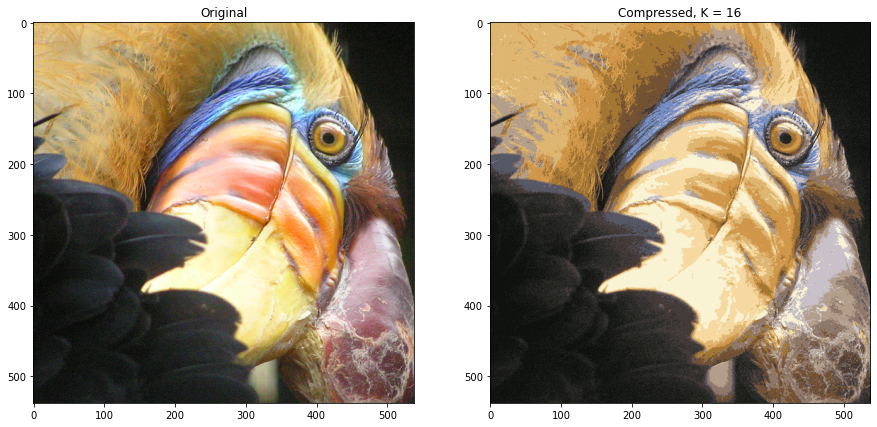

Wall time: 2.25 s


In [30]:
%%time
img_path = r'C:\Users\a2d2\Desktop\bird_large.tiff'

img = plt.imread(img_path)

img_vec = img.reshape(-1, 3).astype(int)

num, C = V_kmeans(img_vec, 16, tol=0.05)

img_compress_vec = np.empty((img_vec.shape))

for i in range(C.shape[0]):

    img_compress_vec[num == i] = C[i, :]
    
img_compress = img_compress_vec.reshape(img.shape).astype(int)

fig, ax = plt.subplots(ncols=2, figsize=(15, 15))

ax[0].imshow(img)
ax[0].set_title('Original')

ax[1].imshow(img_compress)
ax[1].set_title(f'Compressed, K = {C.shape[0]}')

plt.show()